In [1]:
import shutil

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import requests
import base64
from io import BytesIO
import h5py
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
def pil_to_base64(pil_img):
    im_file = BytesIO()
    pil_img.save(im_file, format="PNG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    im_b64 = base64.b64encode(im_bytes)

    return im_b64

In [6]:
def display(in_img, res):
    x_ext = int(res["size"] / 2)
    y_ext = int(res["size"] / 2)
    start_point = (res["x"] - x_ext, res["y"] - y_ext)
    end_point = (res["x"] + x_ext, res["y"] + y_ext)
    res_img = np.asarray(in_img)
    res_img = cv2.rectangle(res_img, start_point, end_point, (255, 0, 0), 2)
    plt.style.use("dark_background")
    plt.imshow(Image.fromarray(res_img))
    plt.show()

{'found': True, 'size': 25, 'x': 68, 'y': 38}


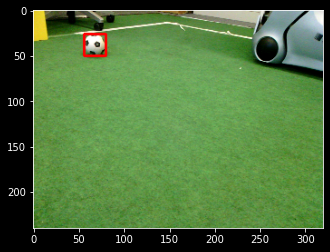

In [10]:
#img1 = Image.open(open("../cur.png", 'rb'))
img1 = Image.open(open("../output_raw/20.png", 'rb'))
bim = pil_to_base64(img1)
res = requests.post("http://localhost:5000/analyse", data=bim).json()
print(res)
display(img1,res)

# validate network

In [91]:
in_dir = "/home/philipp/uni/RoboCup/rc/data/full_dataset/train/"
in_files = os.listdir(in_dir)
in_files = list(filter(lambda x: "_" not in x, in_files))
print(f"validate {len(in_files)} files")
tp = 0
fp = 0
fn = 0
for in_file in tqdm(in_files):
    with h5py.File(os.path.join(in_dir, in_file), 'r') as h5:

        img = np.asarray(h5["raw"][:], dtype=float)
        img1 = Image.fromarray((img * 255).astype(np.uint8))
        bim = pil_to_base64(img1)

        res = requests.post("http://localhost:5000/analyse", json={"b64_img": bim}).json()

        if not res["found"]:
            fn += 1
            continue
        x_ext = int(res["w"] / 2)
        y_ext = int(res["h"] / 2)
        start_point = (res["x"] - x_ext, res["y"] - y_ext)
        end_point = (res["x"] + x_ext, res["y"] + y_ext)
        label = 0
        if np.count_nonzero(h5["mask"][start_point[1]:end_point[1], start_point[0]:end_point[0]]) == 0:
            fp += 1
            label = 0
        else:
            tp += 1
            label = 1

print("fp", fp, "tp", tp, "fn", fn)

validate 99 files


  0%|          | 0/99 [00:00<?, ?it/s]

fp 13 tp 74 fn 12


## validation
fp: 13, tp: 74, fn: 12, sum: 99